In [1]:
import librosa
import librosa.display as ldisplay
import numpy as np
import pandas as pd
import os
from pathlib import Path
import math

In [2]:
target_sr = 16000
output_dir = "./npy/"

In [3]:
wavs = [path for path in Path('./wavs/').rglob('*.wav')]
jsons = [path for path in Path('./wavs/').rglob('*.json')]

In [4]:
%%time

meta_info = []
for i,wav in enumerate(wavs):
    if i % 10 == 0:
        print(i)
    wav_file, wav_sr = librosa.load(wav, sr=librosa.core.get_samplerate(wav))
    
    meta_info.append({
        "file": wav,
        "sample_rate": wav_sr,
        "shape": wav_file.shape,
        "duration": librosa.core.get_duration(wav_file)
    })

meta_info = pd.DataFrame(meta_info)
meta_info.to_csv("meta_info.csv", index=False)

0
10
20
30
40
50
Wall time: 24.9 s


In [5]:
meta_info.sample(n=4)

,file,sample_rate,shape,duration
47,wavs\20-382.wav,16000,"(50495617,)",2290.050658
6,wavs\19-108.wav,16000,"(58240897,)",2641.310522
24,wavs\19-511.wav,16000,"(79560960,)",3608.206803
41,wavs\20-222.wav,16000,"(80037889,)",3629.836236


In [6]:
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio

In [7]:
df = pd.read_json(jsons[0])
df['file'] = wavs[0].name
df['line'] = df.index
df['duration'] = df['end'] - df['start']
df['start_idx'] = np.floor(df['start']*wav_sr).astype(int)
df['end_idx'] = np.ceil(df['end']*wav_sr).astype(int)
df['word_count'] = df['text'].apply(lambda x: len(x.split(" ")))

data = df.loc[(df['word_count'] >= 40) & (df['speaker_role'] == 'scotus_justice')].copy().reset_index(drop=True)
print(f'{df.shape[0]} transcript lines')
print(f"{data.shape[0]} viable segments")

150 transcript lines
37 viable segments


In [8]:
full_data = pd.read_csv('full_data.csv')
frames = full_data['end_idx'] - full_data['start_idx']
max_frames = math.ceil(frames.describe(percentiles=[0.99])["99%"])

### Preprocess Audio First, Save to Numpy Arrays

- Question: When to standardize data? At what level (the individual array, or the entire corpus?)
- Question: Range of Frequencies for pyin
- Question: Parameters for Onset Detection
- Question: What is the process of going from the segment frames to the pyin/onset frames


1. Load Audio
1. Load Metdata
1. Resample
1. Rechannel
1. Pad/Truncate
1. Pitch
    - f0
    - voiced_flag
    - voiced_prob
1. Onset
    - Onset Strength
    - Onset Frames

In [9]:
# File Path
file_path = wavs[0]

# Load in audio
audio_array, audio_sr = librosa.load(file_path, sr=librosa.core.get_samplerate(file_path))

# Load in transcript
transcript = pd.read_json(os.path.join(file_path.parent,file_path.name.replace(".wav",".json")))
transcript["file"] = file_path.name
transcript["line"] = transcript.index
transcript['word_count'] = transcript['text'].apply(lambda x: len(x.split(" ")))

transcript = transcript.loc[(transcript['word_count'] >= 40) & (transcript['speaker_role'] == 'scotus_justice')].copy()
transcript = transcript.reset_index(drop=True)

In [10]:
# One time for all audio
def resample(audio, current_sr, target_sr):
    if current_sr == target_sr:
        return audio
    else:
        new_audio = librosa.resample(audio, current_sr, target_sr)
        return new_audio
    
def rechannel(audio, current_shape, target_channel):
    if target_channel == 1:
        if len(current_shape) == 1:
            return audio
        else:
            new_audio = librosa.to_mono(audio)
            return new_audio
    else:
        if len(current_shape) == 2:
            return audio
        else:
            new_audio = np.array([audio, audio])
            return new_audio

new_audio_array = resample(audio_array, audio_sr, target_sr)   
new_audio_array = rechannel(new_audio_array, new_audio_array.shape, 1)   

       
        
# Indices to break up audio clip into segments        
transcript['start_idx'] = np.floor(df['start']*target_sr).astype(int)
transcript['end_idx'] = np.ceil(df['end']*target_sr).astype(int)


row = dict(transcript.iloc[0])
segment = new_audio_array[row['start_idx']:row['end_idx']]

# Segment Level ---> Do on load. Save out pitch and onset beforehand. 
def pad_truncate(audio, target_len):
    if audio.shape[0] >= target_len:
        return audio[:target_len]
    else:
        padded = np.zeros(target_len)
        padded[0:audio.shape[0]] = audio
        return padded
    

# segment = pad_truncate(segment, max_frames)

In [15]:
print(segment.shape)
print(max_frames)

(101760,)
1955840


In [12]:
%%time
f0, voiced_flag, voiced_probs = librosa.pyin(segment, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C5'))

onset_strengths = librosa.onset.onset_strength(y=segment, sr=target_sr)
onset_frames = librosa.onset.onset_detect(y=segment, sr=target_sr, units='frames')
onset_flags = np.zeros(onset_strengths.shape[0])
onset_flags[onset_frames] = 1

Wall time: 519 ms


C:\Users\yagne\anaconda3\envs\audio\lib\site-packages\librosa\filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


In [13]:
f0_inputed = np.nan_to_num(f0, nan=0.0)

In [14]:
f0_inputed.shape, voiced_flag.shape, voiced_probs.shape, onset_strengths.shape, onset_flags.shape

((199,), (199,), (199,), (199,), (199,))

In [166]:
full_array = np.column_stack((f0_inputed, voiced_flag, voiced_probs, onset_strengths, onset_flags))
np.save(f"{output_dir}test_small.npy",full_array, )

In [167]:
times = librosa.times_like(f0)

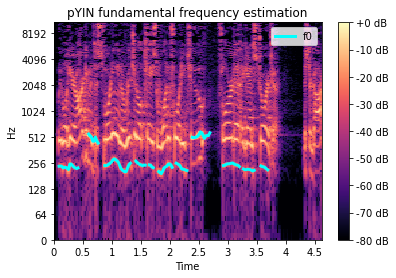

In [168]:
import matplotlib.pyplot as plt

D = librosa.amplitude_to_db(np.abs(librosa.stft(segment)), ref=np.max)

fig, ax = plt.subplots()

img = ldisplay.specshow(D, x_axis='time', y_axis='log', ax=ax)

ax.set(title='pYIN fundamental frequency estimation')

fig.colorbar(img, ax=ax, format="%+2.f dB")

ax.plot(times, f0, label='f0', color='cyan', linewidth=3)

ax.legend(loc='upper right')

In [140]:
a = np.zeros(onset_strengths.shape[0])
a[onset_frames] = 1
a.sum()

31.0